<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session10/FinalS10Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Albumentation and Apex Package**

In [117]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation libraries is successfully installed!"
!pip install apex > /dev/null && echo "Apex library is successfully installed!" ##Required fro LR finder for mixed precissions

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-csyb49jw
Albumentation libraries is successfully installed!
Apex library is successfully installed!


## **Mount Drive and Unzip data**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/API'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/API/Models"
sys.path.append(folder)

ERROR! Session/line number was not unique in database. History logging moved to new session 64


## **Import required files**

In [0]:
%matplotlib inline
import torch
import train_test_loader
import show_images
from ResnetModel import ResNet18 
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Finder import LRFinder


## **Abumentation Transforms**

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=2, max_h_size=9,max_w_size = 9,p=0.7) 
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


## **Load Train Test Data**

In [0]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


## **Some training data**

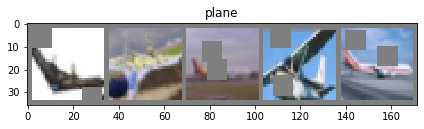

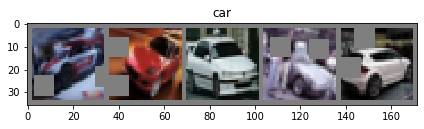

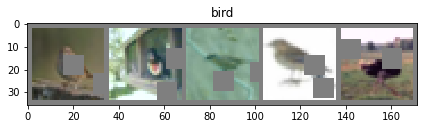

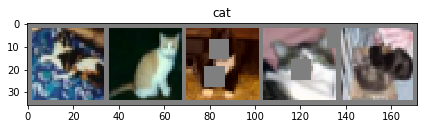

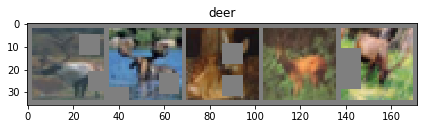

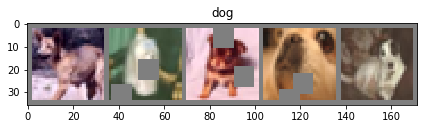

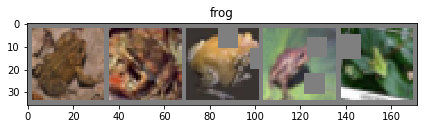

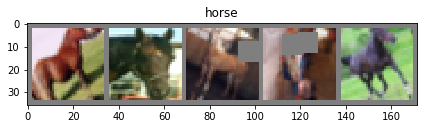

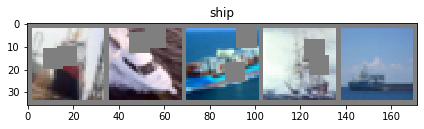

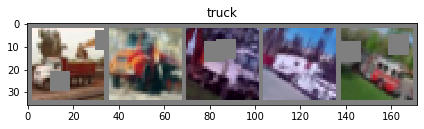

In [0]:
show_images.show_train_data(trainloader, classes)

## **Print Model Summary**

In [120]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18(dropout=0.0).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **LR Finder - Finds the best possible LR**

In [27]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


## **Plot Lr**

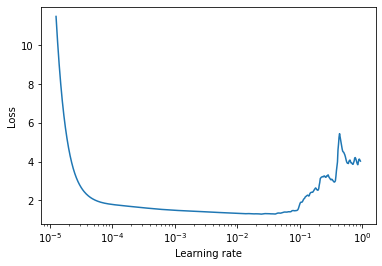

In [28]:
lr_finder.plot()

## **Extract the best LR**

In [0]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

In [0]:
lr_finder.reset()

## **Initialise Loss funtion, Optimizer, Schedular**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

## **Train the Model for 50 Epochs**

In [35]:
test_loss = []
test_acc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/API/bestmodel.pt")
 

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.02417315480804103


Loss=0.9801292419433594 Batch_id=390 Accuracy=54.71: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.0087, Accuracy: 6056/10000 (60.56%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.02417315480804103


Loss=0.9135756492614746 Batch_id=390 Accuracy=65.06: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]



Test set: Average loss: 0.0071, Accuracy: 6888/10000 (68.88%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.02417315480804103


Loss=0.7621896862983704 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]



Test set: Average loss: 0.0052, Accuracy: 7651/10000 (76.51%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.02417315480804103


Loss=0.7729203701019287 Batch_id=390 Accuracy=73.86: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]



Test set: Average loss: 0.0055, Accuracy: 7696/10000 (76.96%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.02417315480804103


Loss=0.9077618718147278 Batch_id=390 Accuracy=76.07: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]



Test set: Average loss: 0.0048, Accuracy: 7894/10000 (78.94%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.02417315480804103


Loss=0.8235638737678528 Batch_id=390 Accuracy=77.75: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 0.0044, Accuracy: 8102/10000 (81.02%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.02417315480804103


Loss=0.5088681578636169 Batch_id=390 Accuracy=79.48: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]



Test set: Average loss: 0.0041, Accuracy: 8248/10000 (82.48%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.02417315480804103


Loss=0.5302332043647766 Batch_id=390 Accuracy=80.74: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]



Test set: Average loss: 0.0038, Accuracy: 8381/10000 (83.81%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 9 LR: 0.02417315480804103


Loss=0.4158271849155426 Batch_id=390 Accuracy=81.87: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8211/10000 (82.11%)

EPOCH: 10 LR: 0.02417315480804103


Loss=0.738628089427948 Batch_id=390 Accuracy=82.94: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8255/10000 (82.55%)

EPOCH: 11 LR: 0.02417315480804103


Loss=0.4349864423274994 Batch_id=390 Accuracy=83.95: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]



Test set: Average loss: 0.0037, Accuracy: 8416/10000 (84.16%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 12 LR: 0.02417315480804103


Loss=0.5277715921401978 Batch_id=390 Accuracy=84.36: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8316/10000 (83.16%)

EPOCH: 13 LR: 0.02417315480804103


Loss=0.376379132270813 Batch_id=390 Accuracy=85.41: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 0.0033, Accuracy: 8567/10000 (85.67%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 14 LR: 0.02417315480804103


Loss=0.43603602051734924 Batch_id=390 Accuracy=85.87: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]



Test set: Average loss: 0.0031, Accuracy: 8688/10000 (86.88%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 15 LR: 0.02417315480804103


Loss=0.37958115339279175 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:31<00:00, 12.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8682/10000 (86.82%)

EPOCH: 16 LR: 0.02417315480804103


Loss=0.29903364181518555 Batch_id=390 Accuracy=86.69: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]



Test set: Average loss: 0.0031, Accuracy: 8710/10000 (87.10%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 17 LR: 0.02417315480804103


Loss=0.3643481731414795 Batch_id=390 Accuracy=87.47: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]



Test set: Average loss: 0.0028, Accuracy: 8758/10000 (87.58%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 18 LR: 0.02417315480804103


Loss=0.29125505685806274 Batch_id=390 Accuracy=87.88: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8758/10000 (87.58%)

EPOCH: 19 LR: 0.02417315480804103


Loss=0.37369805574417114 Batch_id=390 Accuracy=88.18: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8732/10000 (87.32%)

EPOCH: 20 LR: 0.02417315480804103


Loss=0.3630213737487793 Batch_id=390 Accuracy=88.81: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8746/10000 (87.46%)

EPOCH: 21 LR: 0.02417315480804103


Loss=0.25161415338516235 Batch_id=390 Accuracy=88.95: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]



Test set: Average loss: 0.0027, Accuracy: 8866/10000 (88.66%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 22 LR: 0.02417315480804103


Loss=0.32122236490249634 Batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]



Test set: Average loss: 0.0025, Accuracy: 8957/10000 (89.57%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 23 LR: 0.02417315480804103


Loss=0.3950091004371643 Batch_id=390 Accuracy=89.46: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8920/10000 (89.20%)

EPOCH: 24 LR: 0.02417315480804103


Loss=0.6364047527313232 Batch_id=390 Accuracy=89.51: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8606/10000 (86.06%)

EPOCH: 25 LR: 0.02417315480804103


Loss=0.2778260111808777 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [00:31<00:00, 12.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8857/10000 (88.57%)

EPOCH: 26 LR: 0.02417315480804103


Loss=0.29707077145576477 Batch_id=390 Accuracy=90.19: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8911/10000 (89.11%)

EPOCH: 27 LR: 0.002417315480804103


Loss=0.0855853334069252 Batch_id=390 Accuracy=93.40: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]



Test set: Average loss: 0.0018, Accuracy: 9248/10000 (92.48%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 28 LR: 0.002417315480804103


Loss=0.18822640180587769 Batch_id=390 Accuracy=94.63: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]



Test set: Average loss: 0.0017, Accuracy: 9275/10000 (92.75%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 29 LR: 0.002417315480804103


Loss=0.09314931929111481 Batch_id=390 Accuracy=95.12: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 9262/10000 (92.62%)

EPOCH: 30 LR: 0.002417315480804103


Loss=0.046108029782772064 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]



Test set: Average loss: 0.0017, Accuracy: 9299/10000 (92.99%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 31 LR: 0.002417315480804103


Loss=0.10882721841335297 Batch_id=390 Accuracy=95.48: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.0016, Accuracy: 9319/10000 (93.19%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 32 LR: 0.002417315480804103


Loss=0.20241372287273407 Batch_id=390 Accuracy=95.84: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 9314/10000 (93.14%)

EPOCH: 33 LR: 0.002417315480804103


Loss=0.16878870129585266 Batch_id=390 Accuracy=95.89: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]



Test set: Average loss: 0.0016, Accuracy: 9337/10000 (93.37%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 34 LR: 0.002417315480804103


Loss=0.07771529257297516 Batch_id=390 Accuracy=96.07: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9329/10000 (93.29%)

EPOCH: 35 LR: 0.002417315480804103


Loss=0.08976830542087555 Batch_id=390 Accuracy=96.20: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]



Test set: Average loss: 0.0016, Accuracy: 9349/10000 (93.49%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 36 LR: 0.002417315480804103


Loss=0.09732498228549957 Batch_id=390 Accuracy=96.58: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9332/10000 (93.32%)

EPOCH: 38 LR: 0.002417315480804103


Loss=0.037768468260765076 Batch_id=390 Accuracy=96.55: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9341/10000 (93.41%)

EPOCH: 39 LR: 0.002417315480804103


Loss=0.13054513931274414 Batch_id=390 Accuracy=96.65: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9325/10000 (93.25%)

EPOCH: 40 LR: 0.002417315480804103


Loss=0.06478974223136902 Batch_id=390 Accuracy=96.88: 100%|██████████| 391/391 [00:31<00:00, 12.59it/s]



Test set: Average loss: 0.0016, Accuracy: 9376/10000 (93.76%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 41 LR: 0.0002417315480804103


Loss=0.16796565055847168 Batch_id=390 Accuracy=97.07: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9373/10000 (93.73%)

EPOCH: 42 LR: 0.0002417315480804103


Loss=0.059816163033246994 Batch_id=390 Accuracy=97.18: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]



Test set: Average loss: 0.0016, Accuracy: 9380/10000 (93.80%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 43 LR: 0.0002417315480804103


Loss=0.052515529096126556 Batch_id=390 Accuracy=97.08: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9375/10000 (93.75%)

EPOCH: 44 LR: 0.0002417315480804103


Loss=0.07622862607240677 Batch_id=390 Accuracy=97.21: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9375/10000 (93.75%)

EPOCH: 45 LR: 0.0002417315480804103


Loss=0.09773606061935425 Batch_id=390 Accuracy=97.29: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9372/10000 (93.72%)

EPOCH: 46 LR: 0.0002417315480804103


Loss=0.05848351866006851 Batch_id=390 Accuracy=97.21: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9378/10000 (93.78%)

EPOCH: 47 LR: 0.0002417315480804103


Loss=0.13244099915027618 Batch_id=390 Accuracy=97.26: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9371/10000 (93.71%)

EPOCH: 48 LR: 0.0001


Loss=0.08270511031150818 Batch_id=390 Accuracy=97.22: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9373/10000 (93.73%)

EPOCH: 49 LR: 0.0001


Loss=0.06446675211191177 Batch_id=390 Accuracy=97.37: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9377/10000 (93.77%)

EPOCH: 50 LR: 0.0001


Loss=0.0755913034081459 Batch_id=390 Accuracy=97.30: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]



Test set: Average loss: 0.0016, Accuracy: 9372/10000 (93.72%)



## **Load the Best Accuracy Model**

In [85]:

model = ResNet18(dropout=0.0).to(device)
optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/API/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


## **Evaluate the class wise accuracy**

In [43]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 94 %
Accuracy of   car : 97 %
Accuracy of  bird : 93 %
Accuracy of   cat : 85 %
Accuracy of  deer : 94 %
Accuracy of   dog : 89 %
Accuracy of  frog : 95 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %


## **Plot accurary change in test and train**

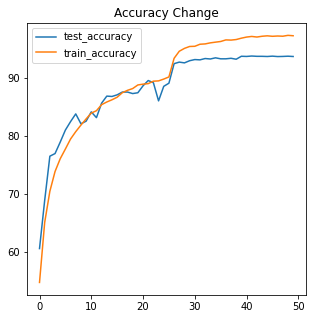

In [90]:
curves = [(test_acc,"test_accuracy"),(train_acc,"train_accuracy")]
evaluate.plot_curve(curves =curves ,title = "Accuracy Change",Figsize = (5,5))



## **Plot Loss Change in Test**
(Couldn't plot both the train and test loss together because both has different scale. So visualisation will not be proper)

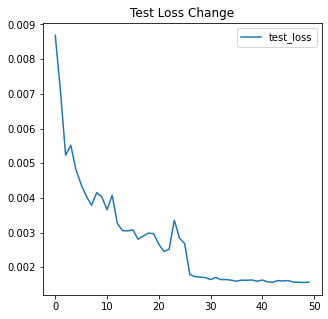

In [111]:
curves = [(test_loss,"test_loss")]
evaluate.plot_curve(curves =curves ,title = "Test Loss Change",Figsize = (5,5))

## **Plot Loss Change in train**

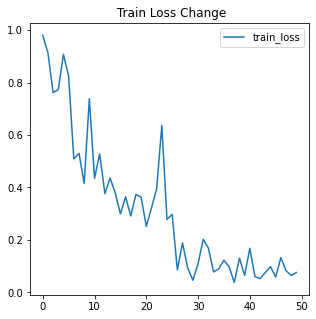

In [110]:
curves = [(train_loss,"train_loss")]
evaluate.plot_curve(curves =curves ,title = " Train Loss Change",Figsize = (5,5))

## **Extract 25 misclassified_images**

In [0]:
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)


## **GradCam View of misclassified images(for 4 layers also)**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


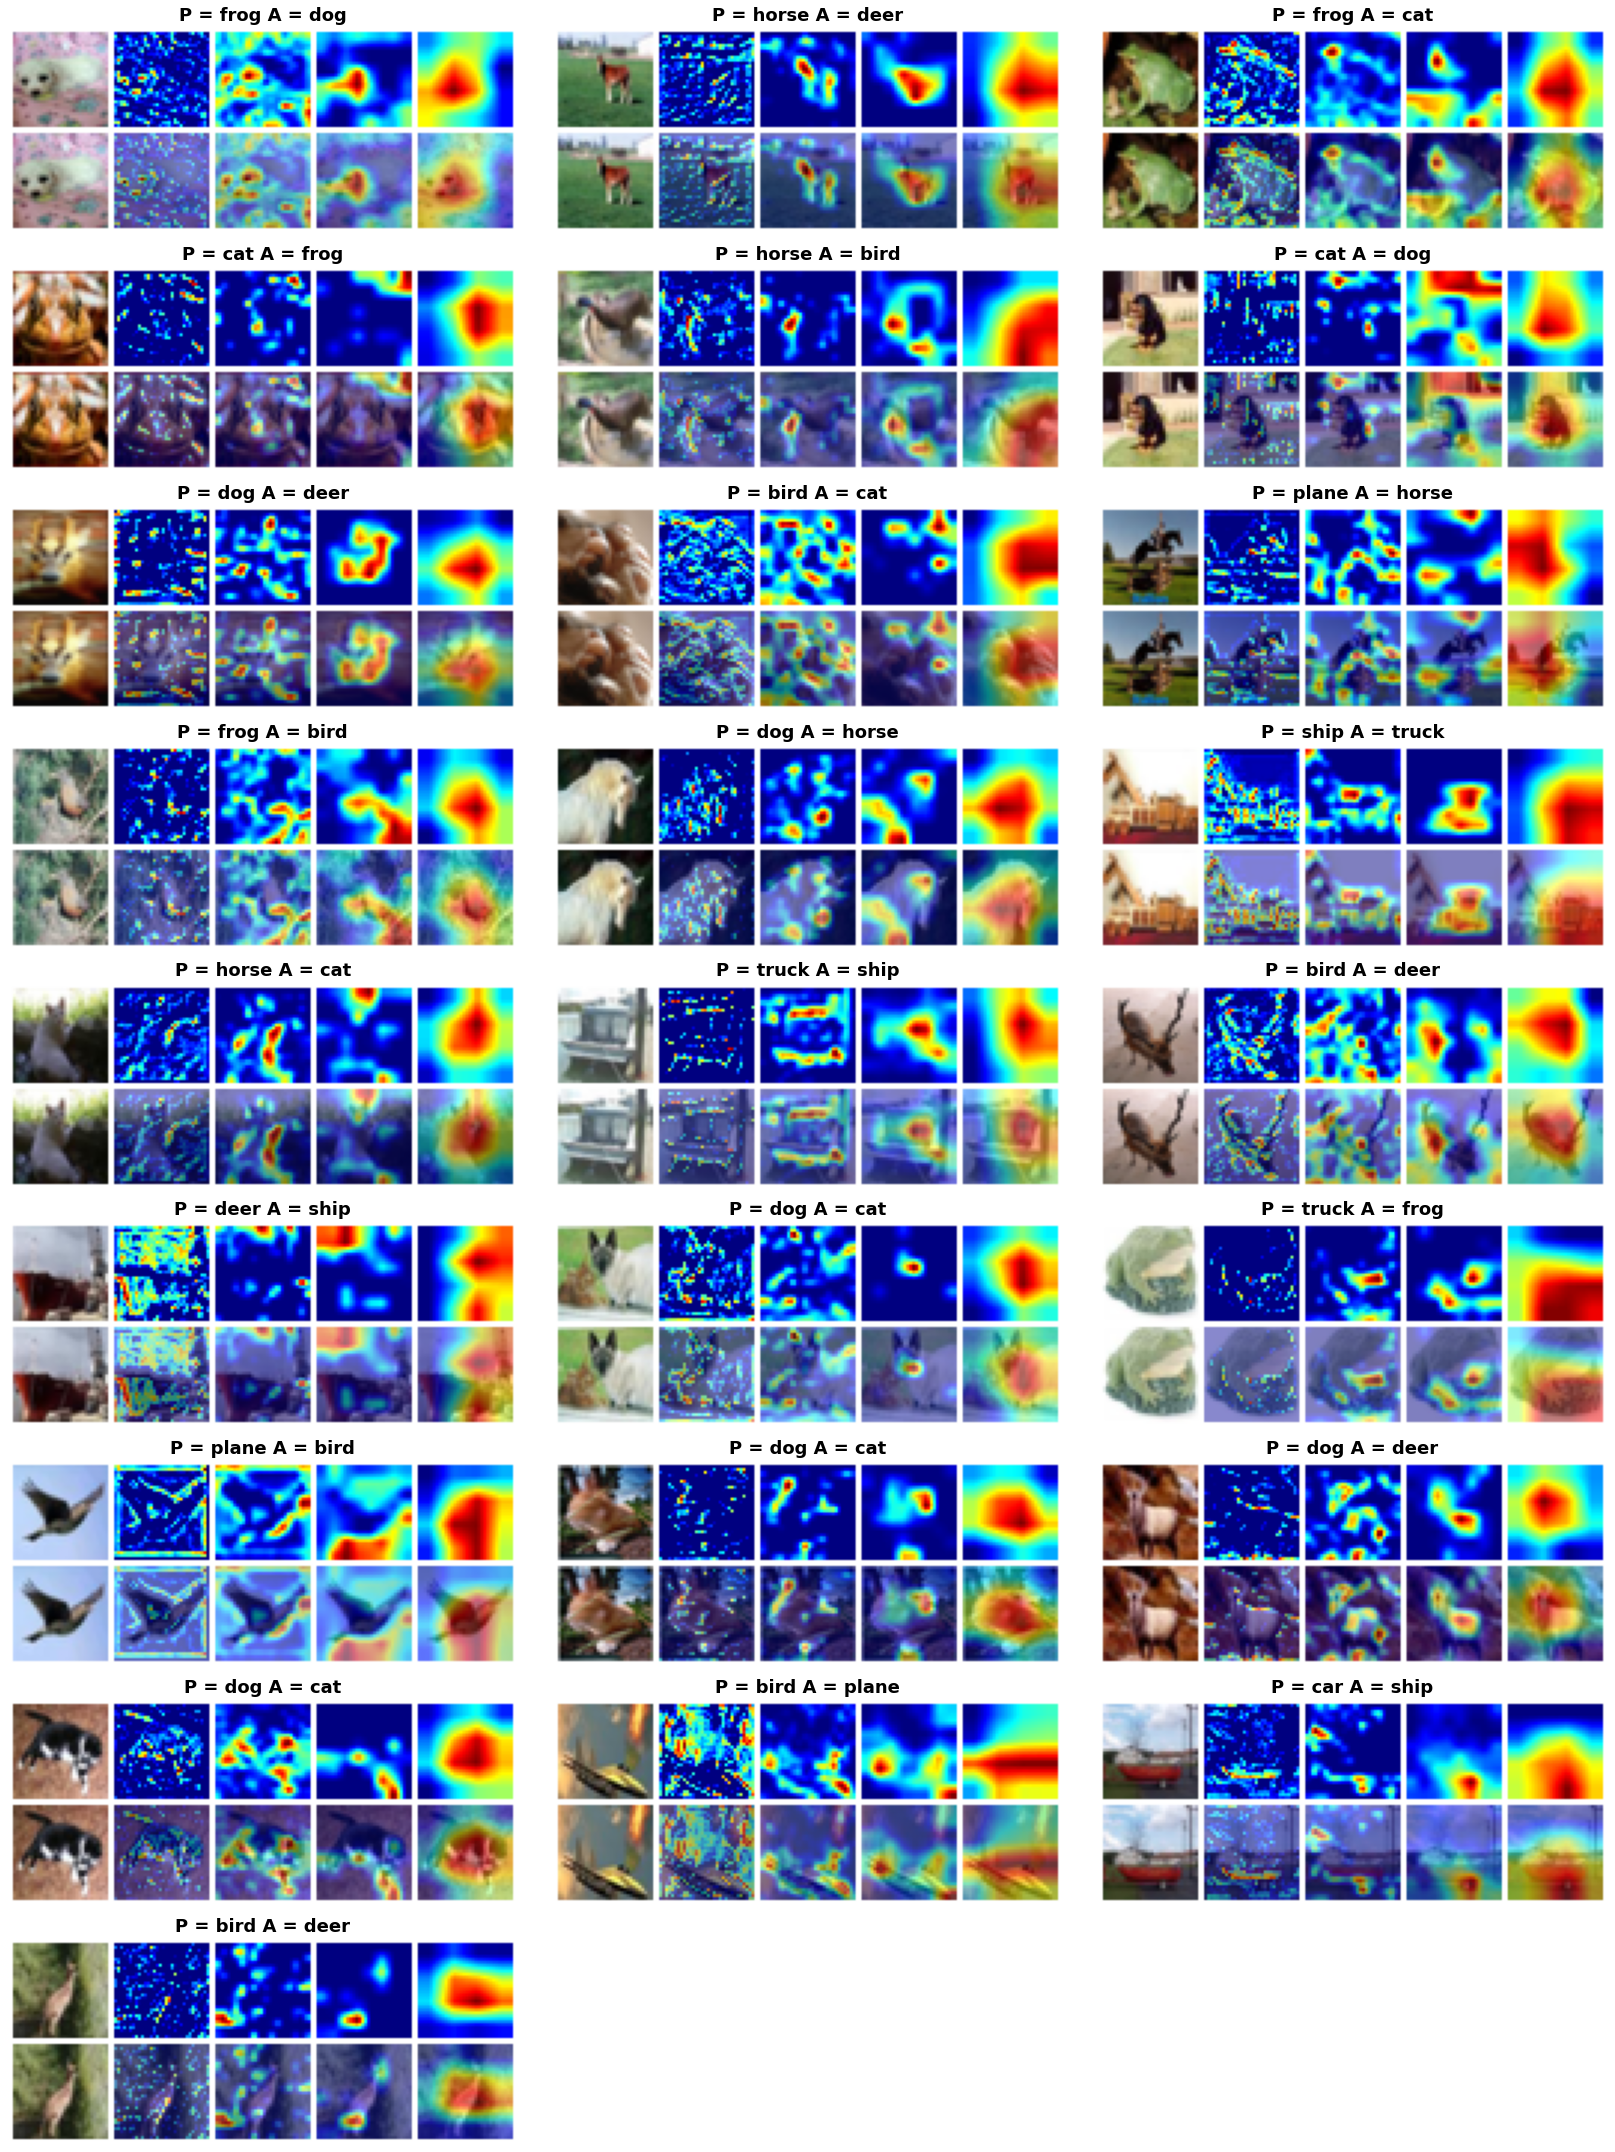

In [109]:

from GradCam import GradCamView
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
GradCamView(miscalssified_images,model,classes,layers )



  